In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np  # 导入numpy库
import pandas as pd  # 导入pandas库
from sklearn.ensemble import GradientBoostingRegressor  # 集成方法回归库
from sklearn.model_selection import GridSearchCV  # 导入交叉检验库
import matplotlib.pyplot as plt  # 导入图形展示库
from sklearn.ensemble import GradientBoostingRegressor

TRAIN_DATA_PATH = './data/zhengqi_train.txt'
TEST_DATA_PATH = './data/zhengqi_test.txt'


def LoadData():
    # load data from txt file
    train_data = pd.read_csv(TRAIN_DATA_PATH, sep='\t')
    test_data = pd.read_csv(TEST_DATA_PATH, sep='\t')
    return (train_data, test_data)

def main():
    (train_data, test_data) = LoadData()

    train_data_x = train_data.drop(['target'], axis=1)
    train_data_y = train_data['target']

    if True:
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=40)
        model_gbr = GradientBoostingRegressor()  # 建立GradientBoostingRegressor回归对象
        if True:
            parameters = {'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
                          'loss': ['ls', 'lad', 'huber', 'quantile'],
                          'max_depth': [1, 3, 9, 12, 15, 18, 21],
                          'max_features': ['sqrt'],
                          'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14],
                          'min_samples_split': [10, 20, 30, 40, 50, 60, 70],
                          'n_estimators': [100, 200, 300, 400, 500, 600, 700],
                          'random_state': [10, 20, 30, 40, 50, 60, 70],
                          'subsample': [0.1, 0.3, 0.6, 0.9],
                          'alpha': [0.1, 0.3]}  # 定义要优化的参数信息            
            model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=5)  # 建立交叉检验模型对象
            model_gs.fit(X_train, Y_train)  # 训练交叉检验模型
            print('Best score is:', model_gs.best_score_)  # 获得交叉检验模型得出的最优得分
            print('Best parameter is:', model_gs.best_params_)  # 获得交叉检验模型得出的最优参数

            model_best = model_gs.best_estimator_  # 获得交叉检验模型得出的最优模型对象
            model_best.fit(X_train, Y_train)  # 训练最优模型
            Y_pred = model_best.predict(X_test)
            print(mean_squared_error(Y_test, Y_pred))

    if False:
        X_train, X_test, Y_train, Y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=40)
        params = {'learning_rate': 0.03, 'loss': 'huber', 'max_depth': 14, 'max_features': 'sqrt',
                  'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 300,
                  'random_state': 10, 'subsample': 0.8}
        clf = GradientBoostingRegressor(**params)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print(mean_squared_error(Y_test, Y_pred))

    '''结果预测'''
    if False:
        test_data_y = clf.predict(test_data)
        res_pd = pd.DataFrame(test_data_y, columns=['target'])
        res_pd.to_csv("./submit/njit_77.txt", index=False, header=False)

if __name__ == '__main__':
    main()

0.09127313026288589


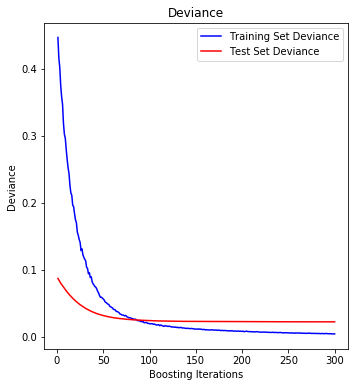

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import pca
from sklearn.ensemble import GradientBoostingRegressor

TRAIN_DATA_PATH = './data/zhengqi_train.txt'
TEST_DATA_PATH = './data/zhengqi_test.txt'


def LoadData():
    # load data from txt file
    train_data = pd.read_csv(TRAIN_DATA_PATH, sep='\t')
    test_data = pd.read_csv(TEST_DATA_PATH, sep='\t')
    return (train_data, test_data)


def NormalizeData(train_data):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    return (train_data - mean)/std

def DrawLearningRate(clf, params, train_data, X_test, y_test, y_pred):
    ###############################################################################
    # Plot training deviance

    # compute test set deviance
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')    
    
def main():
    (train_data, test_data) = LoadData()

    train_data_x = train_data.drop(['target'], axis=1)
    train_data_y = train_data['target']

    train_data_x = NormalizeData(train_data_x)
    
    X_train, X_test, Y_train, Y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=40)
    params={'learning_rate':0.03, 'loss':'huber', 'max_depth':14, 'max_features':'sqrt', 'min_samples_leaf':10,  
            'min_samples_split':40, 'n_estimators':300, 'random_state':10, 'subsample':0.8}
    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    print(mean_squared_error(Y_test, Y_pred))

    DrawLearningRate(clf, params, train_data, X_test, Y_test, Y_pred)
    
    '''结果预测'''
    test_data_y = clf.predict(test_data)

    res_pd = pd.DataFrame(test_data_y, columns=['target'])
    res_pd.to_csv("./submit/njit_77.txt", index=False, header=False)

if __name__ == '__main__':
    main()

**步骤1** 导入库

In [1]:
import numpy as np  # 导入numpy库
import pandas as pd  # 导入pandas库
from sklearn.ensemble import GradientBoostingRegressor  # 集成方法回归库
from sklearn.model_selection import GridSearchCV  # 导入交叉检验库
import matplotlib.pyplot as plt  # 导入图形展示库

**步骤2** 读取数据，该步骤使用pandas的read_table方法读取txt文件，指定数据分隔符为逗号。

In [2]:
raw_data = pd.read_table('./data/zhengqi_train.txt', delimiter='\t')

**步骤3** 数据审查和校验，该步骤包含了数据概览、类型分布、描述性统计值域分布、缺失值审查、相关性分析4个部分。

第一部分 数据概览，目的是查看基本概况、分布规律等。

In [3]:
print ('{:*^60}'.format('Data overview:'))
print (raw_data.tail(2))  # 打印原始数据后2条
print ('{:*^60}'.format('Data dtypes:'))
print (raw_data.dtypes)  # 打印数据类型
print ('{:*^60}'.format('Data DESC:'))
print (raw_data.describe().round(1).T)  # 打印原始数据基本描述性信息

***********************Data overview:***********************
         V0     V1     V2     V3     V4     V5    V6     V7     V8     V9  \
2886 -0.219 -0.282 -0.344 -0.049  0.449 -0.140  0.56  0.583 -0.596  0.904   
2887  0.368  0.380 -0.225 -0.049  0.379  0.092  0.55  0.551  0.244  0.904   

       ...      V29    V30    V31    V32    V33    V34   V35    V36    V37  \
2886   ...    0.216  1.061 -0.051  1.023  0.878  0.610 -0.23 -0.301  0.555   
2887   ...    0.047  0.057 -0.042  0.847  0.534 -0.009 -0.19 -0.567  0.388   

      target  
2886   0.350  
2887   0.417  

[2 rows x 39 columns]
************************Data dtypes:************************
V0        float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V

第二部分查看值域分布，目的是查看分类变量的各个变量的值域分布。在第一部分中发现了属于分类变量中出现了异常分布值，这里需要做下进一步验证。

In [4]:
for col_name in range(0,38):  # 循环读取每个列
    unque_value = np.sort(raw_data["V{0}".format(col_name)].unique())  # 获得列唯一值
    print ('{:*^50}'.format('{1} unique values:{0}').format(unque_value, "V{0}".format(col_name)))  # 打印输出

**************V0 unique values:[-4.335 -4.231 -4.198 ...  2.066  2.092  2.121]***************
**************V1 unique values:[-5.122 -4.777 -4.717 ...  1.842  1.874  1.918]***************
**************V2 unique values:[-3.42  -3.217 -2.848 ...  2.746  2.773  2.828]***************
**************V3 unique values:[-3.956 -3.549 -3.115 ...  2.381  2.403  2.457]***************
**************V4 unique values:[-4.742 -4.211 -4.036 ...  2.285  2.337  2.689]***************
**************V5 unique values:[-2.182 -2.12  -2.042 ...  0.435  0.454  0.489]***************
**************V6 unique values:[-4.576 -4.368 -4.28  ...  1.846  1.867  1.895]***************
**************V7 unique values:[-5.048 -4.959 -4.836 ...  1.9    1.902  1.918]***************
**************V8 unique values:[-4.692 -4.558 -4.342 ...  2.181  2.2    2.245]***************
**************V9 unique values:[-12.891  -8.58   -7.071  -6.478  -6.425  -6.209  -5.562  -5.419  -5.347
  -4.7    -4.269  -3.838  -3.676  -3.192  -3.12   

第三部分 缺失值审查，目的是验证在第一部分中得到的关于price缺失的结论，同时再次确认下其他列的缺失情况。

In [5]:
na_cols = raw_data.isnull().any(axis=0)  # 查看每一列是否具有缺失值
print ('{:*^60}'.format('NA Cols:'))
print (na_cols)  # 查看具有缺失值的列
na_lines = raw_data.isnull().any(axis=1)  # 查看每一行是否具有缺失值
print ('Total number of NA lines is: {0}'.format(na_lines.sum()))  # 查看具有缺失值的行总记录数

**************************NA Cols:**************************
V0        False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
V29       False
V30       False
V31       False
V32       False
V33       False
V34       False
V35       False
V36       False
V37       False
target    False
dtype: bool
Total number of NA lines is: 0


第五部分 相关性分析，主要用来做回归的共线性问题检验。如果存在比较严重的线性问题则需要使用特定算法或做降维处理。

**步骤4** 数据预处理，包括异常值处理、分割数据集两部分。

第一部分 异常值处理。根据步骤3得到的结论，包括price中的缺失值、limit_infor中值域为10的记录以及campaign_fee为33380的记录都要做针对性处理。